## Divide and Conquer-Based 1D CNN Human Activity Recognition

 This prolem was solved by taking inspiration from **Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening** 

 which was proposed by Heeryon Cho and Sang Min Yoon

Human Activity Recognition data consists of 6 labels()

*   WALKING
*  WALKING_UPSTAIRS
* WALKING_DOWNSTAIRS
* SITTING
* STANDING
* LAYING

As we have seen in HAR EDA, we can differentiate dynamic activities(WALKING,WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) and static activities (SITTING,STANDING,LAYING)




> So intially we are building a base line classifier to classify static and dynamic activities and later for static and dybamic activities we are building separate classifiers. Finally we are combining all three classifiers to get better results





In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix as cm
from matplotlib import pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Flatten
from keras.layers.core import Dense, Dropout
from keras.optimizers import RMSprop, adam
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.models import Sequential
import keras
from keras.layers import Conv1D, Input, MaxPooling1D,concatenate,TimeDistributed
from keras.models import Model

In [42]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [43]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [45]:
# Initializing parameters
epochs = 30
batch_size = 30
n_hidden = 32

In [46]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [105]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix_s(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Utility Functions

In [49]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [50]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [65]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals():
    signals_data_train = []
    signals_data_test = []

    for signal in SIGNALS:
        filename_train = f'UCI_HAR_Dataset/train/Inertial Signals/{signal}_train.txt'
        df_train =  _read_csv(filename_train)
        #print(df_train.head())
        # standardizing the data
        s = StandardScaler()
        df_train_std = s.fit_transform(df_train)
        df_train_std_df = pd.DataFrame(df_train_std)
        #print(df_train_std_df.head())
        filename_test = f'UCI_HAR_Dataset/test/Inertial Signals/{signal}_test.txt'
        df_test =  _read_csv(filename_test)
        df_test_std = s.transform(df_test)
        df_test_std_df = pd.DataFrame(df_test_std)
        signals_data_train.append(df_train_std_df.values)
        signals_data_test.append(df_test_std_df.values)
        # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    final_train = np.transpose(signals_data_train, (1, 2, 0))
    final_test = np.transpose(signals_data_test, (1, 2, 0))
    
      # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return final_train, final_test

In [66]:

def load_y_2class(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    
    # Making Class labels for baseline classifier i.e. for all dynamic activities will be labled as 0 and static activities \ 
    # will be labeled as 1
    
    y[y==1] = 0
    y[y==2] = 0
    y[y==3] = 0
    y[y==4] = 1
    y[y==5] = 1
    y[y==6] = 1

    return pd.get_dummies(y).values

In [67]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return y

In [68]:
def load_y_static(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    # intially static activities are labeled as 4,5,6 so we are filtering only static labels
    y_static_con = y>3 # preparing indices for the X_data
    y= y[y_static_con]
    return pd.get_dummies(y).values , y_static_con

In [69]:
def load_data_static():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    
    y_train,y_train_con  = load_y_static('train')
    y_test,y_test_con =load_y_static('test')
    X_train, X_test = load_signals()
    X_train_static = X_train[y_train_con] # taking only static activity labeled data
    X_test_static = X_test[y_test_con]
    

    return X_train_static, X_test_static, y_train, y_test

In [70]:
def load_y_dynamic(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    # intially dynamic activities are labeled as 1,2,3 so we are filtering only dynamic labels
    y_dynamic_con = y<4
    y= y[y_dynamic_con]
    return pd.get_dummies(y).as_matrix() , y_dynamic_con

In [71]:
def load_data_dynamic():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    
    y_train,y_train_con  = load_y_dynamic('train')
    y_test,y_test_con =load_y_dynamic('test')
    X_train, X_test = load_signals()
    X_train_dynamic = X_train[y_train_con] # taking only dynamic activity labeled data
    X_test_dynamic = X_test[y_test_con]
    

    return X_train_dynamic, X_test_dynamic, y_train, y_test

In [72]:
def load_data_2class():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals()
    y_train, y_test = load_y_2class('train'), load_y_2class('test')

    return X_train, X_test, y_train, y_test

In [73]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals()
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

### Loading data

In [74]:
# Loading static data
X_train_static, X_test_static, Y_train_static, Y_test_static = load_data_static()

In [75]:
print("shape of static x_train data",X_train_static.shape)
print("shape of static x_test data",X_test_static.shape)
print("shape of static y_train data",Y_train_static.shape)
print("shape of static y_test data",Y_test_static.shape)

shape of static x_train data (4067, 128, 9)
shape of static x_test data (1560, 128, 9)
shape of static y_train data (4067, 3)
shape of static y_test data (1560, 3)


In [76]:
# Loading dynamic data
X_train_dynamic, X_test_dynamic, Y_train_dynamic, Y_test_dynamic = load_data_dynamic()

C:\Users\sandeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [77]:
print("shape of dynamic x_train data",X_train_dynamic.shape)
print("shape of dynamic x_test data",X_test_dynamic.shape)
print("shape of dynamic y_train data",Y_train_dynamic.shape)
print("shape of dynamic y_test data",Y_test_dynamic.shape)

shape of dynamic x_train data (3285, 128, 9)
shape of dynamic x_test data (1387, 128, 9)
shape of dynamic y_train data (3285, 3)
shape of dynamic y_test data (1387, 3)


In [78]:
# Loading the train and test whole data labeled as 0 and 1 for binary classification
X_train_2, X_test_2, Y_train_2, Y_test_2 = load_data_2class()

In [79]:
# Loading the train and test whole data labeled as 1 to 6 for final classification
X_train, X_test, Y_train, Y_test = load_data()

In [80]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
#n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [0]:
Y_train.shape

(7352,)

### Model for 2 class classifier

In [0]:
# Initiliazing the sequential model
model_2class = Sequential()
model_2class.add(Conv1D(64, kernel_size=3, activation= 'relu',input_shape=(128,9)))
#model_2class.add(Conv1D(12, kernel_size=3, activation= 'relu'))
model_2class.add(Dropout(0.7))
model_2class.add(MaxPooling1D(pool_size=3))
model_2class.add(Flatten())
model_2class.add(Dense(50, activation='relu'))
model_2class.add(Dense(2, activation='softmax'))
model_2class.summary()

W0810 13:30:30.152844 139981487331200 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 126, 64)           1792      
_________________________________________________________________
dropout_2 (Dropout)          (None, 126, 64)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                134450    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 136,344
Trainable params: 136,344
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model_2class.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model_2class.fit(X_train_2,
          Y_train_2,
          batch_size=batch_size,
          validation_data=(X_test_2, Y_test_2),
          epochs=10)

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 2s 252us/step - loss: 0.0415 - acc: 0.9853 - val_loss: 0.0275 - val_acc: 0.9878
Epoch 2/10
7352/7352 [==============================] - 2s 226us/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0340 - val_acc: 0.9888
Epoch 3/10
7352/7352 [==============================] - 2s 226us/step - loss: 1.5267e-04 - acc: 1.0000 - val_loss: 0.0572 - val_acc: 0.9874
Epoch 4/10
7352/7352 [==============================] - 2s 228us/step - loss: 3.0593e-04 - acc: 0.9999 - val_loss: 0.0128 - val_acc: 0.9966
Epoch 5/10
7352/7352 [==============================] - 2s 227us/step - loss: 2.8885e-06 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9878
Epoch 6/10
7352/7352 [==============================] - 2s 227us/step - loss: 3.8072e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9983
Epoch 7/10
7352/7352 [==============================] - 2s 227us/step - loss: 2.6765e-06 - acc: 1.0000 - val_loss: 0.011

In [0]:
# saving the model
model_2class.save("UCI_HAR_Dataset/model_2class_new.h5")

- With 2 class classifier we are classifying static and dynamic activities with 99.9 accuracy

### model for static classifier

* Iam not getting good accuracy with simple architecture so using hyperas to do hyperparameter tuning

In [0]:
def static_model(X_train_static,Y_train_static,X_test_static,Y_test_static):
    model_static = Sequential()
    model_static.add(Conv1D(filters=({{choice([64,32,100])}}), kernel_size=7, activation='relu',kernel_regularizer = l2({{uniform(0, 1)}}),input_shape=(128,9)))
    model_static.add(Dropout({{uniform(0,1)}}))
    model_static.add(MaxPooling1D(pool_size=5))
    model_static.add(Conv1D(filters=({{choice([64,32])}}), kernel_size=5, activation='relu',kernel_regularizer = l2({{uniform(0, 1)}})))
    model_static.add(Dropout({{uniform(0,1)}}))
    model_static.add(Flatten())
    model_static.add(Dense(({{choice([64,32,100])}}), activation='relu'))
    model_static.add(Dense(3, activation='softmax'))
    model_static.compile(loss='categorical_crossentropy',
                  optimizer={{choice(['rmsprop','adam','sgd'])}},
                  metrics=['accuracy'])
    model_static.fit(X_train_static,Y_train_static, epochs=30, batch_size={{choice([16,32])}},validation_data=(X_test_static, Y_test_static), verbose=1)
    score, acc = model.evaluate(X_test_static, Y_test_static, verbose=0)
    print('Test model_static:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [7]:
def data():
    
    SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"]
    # Utility function to read the data from csv file
    def _read_csv_s(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals_s():
             
        signals_data_train = []
        signals_data_test = []

        for signal in SIGNALS:
            
            
            filename_train = f'UCI_HAR_Dataset/train/Inertial Signals/{signal}_train.txt'
            df_train =  _read_csv_s(filename_train)
            #print(df_train.head())
            # standardizing the data
            s = StandardScaler()
            df_train_std = s.fit_transform(df_train)
            df_train_std_df = pd.DataFrame(df_train_std)
            #print(df_train_std_df.head())
            filename_test = f'UCI_HAR_Dataset/test/Inertial Signals/{signal}_test.txt'
            df_test =  _read_csv_s(filename_test)
            df_test_std = s.transform(df_test)
            df_test_std_df = pd.DataFrame(df_test_std)
            signals_data_train.append(df_train_std_df.values)
            signals_data_test.append(df_test_std_df.values)
        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        final_train = np.transpose(signals_data_train, (1, 2, 0))
        final_test = np.transpose(signals_data_test, (1, 2, 0))
        return final_train, final_test
    def load_y_static_s(subset):
        
    
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv_s(filename)[0]
        # intially static activities are labeled as 4,5,6 so we are filtering only static labels
        y_static_con = y>3 # preparing indices for the X_data
        y= y[y_static_con]
        return pd.get_dummies(y).values , y_static_con
    def load_data_static_s():
        """
        Obtain the dataset from multiple files.
        Returns: X_train, X_test, y_train, y_test
        """

        y_train,y_train_con  = load_y_static_s('train')
        y_test,y_test_con =load_y_static_s('test')
        X_train, X_test = load_signals_s()
        X_train_static = X_train[y_train_con] # taking only static activity labeled data
        X_test_static = X_test[y_test_con]
    

        return X_train_static, X_test_static, y_train, y_test
    X_train_static, X_test_static, Y_train_static, Y_test_static = load_data_static_s()
    return X_train_static,Y_train_static,X_test_static,Y_test_static

In [8]:

def static_model(X_train_static,Y_train_static,X_test_static,Y_test_static):
    model_static = Sequential()
    
    model_static.add(Conv1D(filters={{choice([32,64,100])}}, kernel_size=7,activation='relu',
                 kernel_regularizer=l2({{uniform(0,1)}}),input_shape=(128,9)))
    
    model_static.add(Conv1D(filters={{choice([32,64])}}, kernel_size=5, 
                     activation='relu',kernel_regularizer=l2({{uniform(0,1)}})))
    model_static.add(Dropout({{uniform(0.2,0.8)}}))
    model_static.add(MaxPooling1D(pool_size=5))
    model_static.add(Flatten())
    model_static.add(Dense({{choice([32,64])}}, activation='relu'))
    model_static.add(Dense(3, activation='softmax'))
        
    adam = keras.optimizers.Adam(lr={{uniform(0.0005,0.005)}})
    rmsprop = keras.optimizers.RMSprop(lr={{uniform(0.0005,0.005)}})
   
    choiceval = {{choice(['adam', 'rmsprop'])}}
    
    if choiceval == 'adam':
        optim = adam
    else:
        optim = rmsprop
    
    print(model_static.summary())    
    model_static.compile(loss='categorical_crossentropy', optimizer=optim,metrics=['accuracy'])
    
    static_fit = model_static.fit(X_train_static, Y_train_static,
              batch_size={{choice([16,32])}},
              epochs=30,
              verbose=1,
              validation_data=(X_test_static, Y_test_static))
                       
    score, acc = model_static.evaluate(X_test_static, Y_test_static, verbose=0)
    print('Test model_static:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model_static}
   
    

In [9]:
X_train_static,Y_train_static,X_test_static,Y_test_static = data()

In [1]:
# The output of this cell is very large, ecause of this iam facing issues in generating the pdf.
# So jut clearing the output
'''
best_run, best_model = optim.minimize(model=static_model,
                                          data=data,
                                          max_evals=10,
                                          algo=tpe.suggest,
                                          notebook_name='trail_2-divide n concur har', 
                                          trials=Trials())
'''

"\nbest_run, best_model = optim.minimize(model=static_model,\n                                          data=data,\n                                          max_evals=10,\n                                          algo=tpe.suggest,\n                                          notebook_name='trail_2-divide n concur har', \n                                          trials=Trials())\n"

In [11]:
best_run

{'Dropout': 0.6895855955596721,
 'batch_size': 0,
 'choiceval': 1,
 'filters': 2,
 'filters_1': 1,
 'filters_2': 1,
 'l2': 0.6257491042113806,
 'l2_1': 0.4437546321946204,
 'lr': 0.0045882610590084055,
 'lr_1': 0.001515739014339654}

In [88]:
model_static_h = Sequential()
model_static_h.add(Conv1D(filters=64, kernel_size=7,activation='relu',
             kernel_regularizer=l2(best_run["l2"]),input_shape=(128,9)))

model_static_h.add(Conv1D(filters=32, kernel_size=5, 
                 activation='relu',kernel_regularizer=l2(best_run["l2_1"])))
model_static_h.add(Dropout(best_run["Dropout"]))
model_static_h.add(MaxPooling1D(pool_size=5))
model_static_h.add(Flatten())
model_static_h.add(Dense(32, activation='relu'))
model_static_h.add(Dense(3, activation='softmax'))



print(model_static_h.summary())    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 122, 64)           4096      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 118, 32)           10272     
_________________________________________________________________
dropout_14 (Dropout)         (None, 118, 32)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 736)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                23584     
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 99        
Total para

In [89]:
adam = keras.optimizers.Adam(lr=best_run["lr"])

model_static_h.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [91]:
static_fit = model_static_h.fit(X_train_static, Y_train_static,
          batch_size=16,
          epochs=30,
          verbose = 0,
          validation_data=(X_test_static, Y_test_static))

In [92]:
model_static_h.save("model_static_new_trail3.h5")

### model for dynamic classifier

In [0]:
model_dynamic = Sequential()
model_dynamic.add(Conv1D(filters=100, kernel_size=7, activation='relu',kernel_regularizer = l2(0.007),input_shape=(128,9)))
#model_static.add(Conv1D(filters=64, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model_dynamic.add(Dropout(0.7))
#model_static.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model_dynamic.add(MaxPooling1D(pool_size=3))
model_dynamic.add(Flatten())
model_dynamic.add(Dense(50, activation='relu'))
#model_dynamic.add(Dense(32, activation='relu'))
model_dynamic.add(Dense(3, activation='softmax'))
model_dynamic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 122, 100)          6400      
_________________________________________________________________
dropout_19 (Dropout)         (None, 122, 100)          0         
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 40, 100)           0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 4000)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 50)                200050    
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 153       
Total params: 206,603
Trainable params: 206,603
Non-trainable params: 0
_________________________________________________________________


In [0]:
adam = keras.optimizers.Adam(lr=0.003)
model_dynamic.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

In [0]:
# Training the model
history = model_dynamic.fit(X_train_dynamic,
          Y_train_dynamic,
          batch_size=30,
          validation_data=(X_test_dynamic, Y_test_dynamic),
          epochs=20)

Train on 3285 samples, validate on 1387 samples
Epoch 1/20
3285/3285 [==============================] - 3s 869us/step - loss: 0.7284 - acc: 0.7839 - val_loss: 0.3654 - val_acc: 0.9279
Epoch 2/20
3285/3285 [==============================] - 1s 263us/step - loss: 0.1608 - acc: 0.9796 - val_loss: 0.2913 - val_acc: 0.9430
Epoch 3/20
3285/3285 [==============================] - 1s 256us/step - loss: 0.1106 - acc: 0.9906 - val_loss: 0.1790 - val_acc: 0.9654
Epoch 4/20
3285/3285 [==============================] - 1s 260us/step - loss: 0.0880 - acc: 0.9936 - val_loss: 0.2129 - val_acc: 0.9567
Epoch 5/20
3285/3285 [==============================] - 1s 254us/step - loss: 0.0705 - acc: 0.9942 - val_loss: 0.2185 - val_acc: 0.9575
Epoch 6/20
3285/3285 [==============================] - 1s 262us/step - loss: 0.0551 - acc: 0.9970 - val_loss: 0.1359 - val_acc: 0.9668
Epoch 7/20
3285/3285 [==============================] - 1s 258us/step - loss: 0.0518 - acc: 0.9948 - val_loss: 0.1418 - val_acc: 0.9661


In [0]:
model_dynamic.save("model_dynamic_new_trail2.h5")

### Final Prediction

In [95]:
two_class_clf = load_model('model_2class_new.h5')
dynamic_clf = load_model('model_dynamic_new_trail2.h5')


In [96]:
static_clf = load_model('model_static_new_trail3.h5')

In [99]:
def final_predict(data):
    class_pred = two_class_clf.predict(data) #prediction of static and dynamic
    prob_compare =  np.argmax(class_pred, axis=1) #taking index of max probale class
    # prob_compare will have values of 0 and 1. 0 is dynamic label,1is dynamic label
    # So now we have to send dynamic predicted label to dynamic classifier
    # and send static predicted label to static classifier
    dynamic_data = data[prob_compare==0] #Dynamic data
    dynamic_pred = dynamic_clf.predict(dynamic_data) #predicting label with dynamic classifier
    dynamic_label_pred = np.argmax(dynamic_pred,axis=1) #taking index of max probale class
    # dynamic_label_pred contains index of max probable class i.e 0,1 or 2
    # But our actual classes are 1,2 and 3.
    # So adding 1 to the predicted class to get actual class labels
    dynamic_ACTlabel_pred = dynamic_label_pred + 1
   
    static_data = data[prob_compare==1] #static data
    static_pred = static_clf.predict(static_data) #predicting label with static classifier
    static_label_pred = np.argmax(static_pred,axis=1) #taking index of max probale class
    # static_label_pred contains index of max probable class i.e 0,1 or 2
    # But our actual classes are 4,5 and 6.
    # So adding 4 to the predicted class to get actual class labels
    static_ACTlabel_pred = static_label_pred + 4
    
    # Now we got prediction for static and dynamic data
    # But we need in combine format
    
    static,dynamic = 0,0 
    final_prediction = []
    for class_2 in prob_compare:
        if class_2 == 0:
            final_prediction.append(dynamic_ACTlabel_pred[dynamic])
            dynamic = dynamic + 1
        else:
            final_prediction.append(static_ACTlabel_pred[static])
            static = static + 1 
    return final_prediction
  

In [114]:
def plot_confusion_matrix(test_y, predict_y):
    C = cm(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels =[ 'WALKING',
    'WALKING_UPSTAIRS',
    'WALKING_DOWNSTAIRS',
    'SITTING',
    'STANDING',
    'LAYING']
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [100]:
train_pred = final_predict(X_train)
print('Train data Accuracy',accuracy_score(Y_train,train_pred))
test_pred = final_predict(X_test)
print('Test data Accuracy',accuracy_score(Y_test,test_pred))


Train data Accuracy 0.999455930359086
Test data Accuracy 0.9491007804546997


-------------------- Confusion matrix --------------------


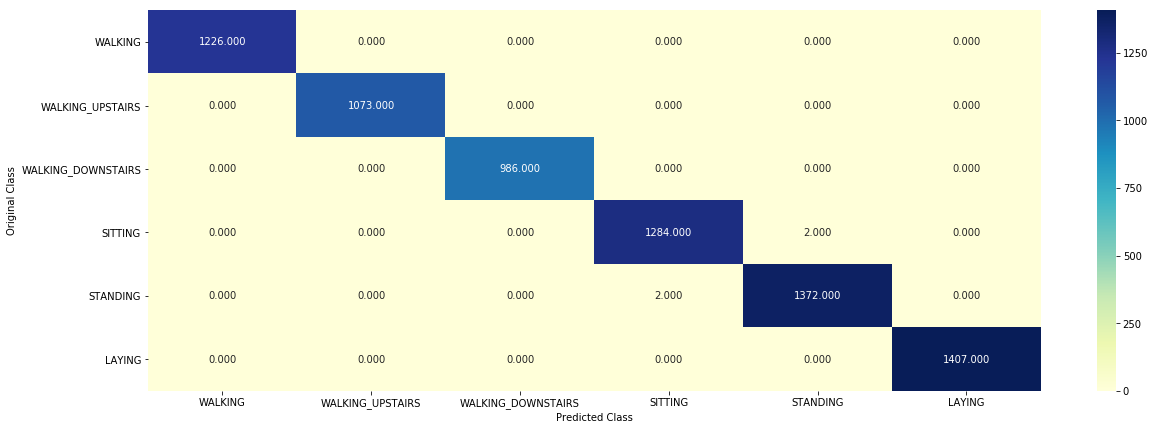

-------------------- Precision matrix (Columm Sum=1) --------------------


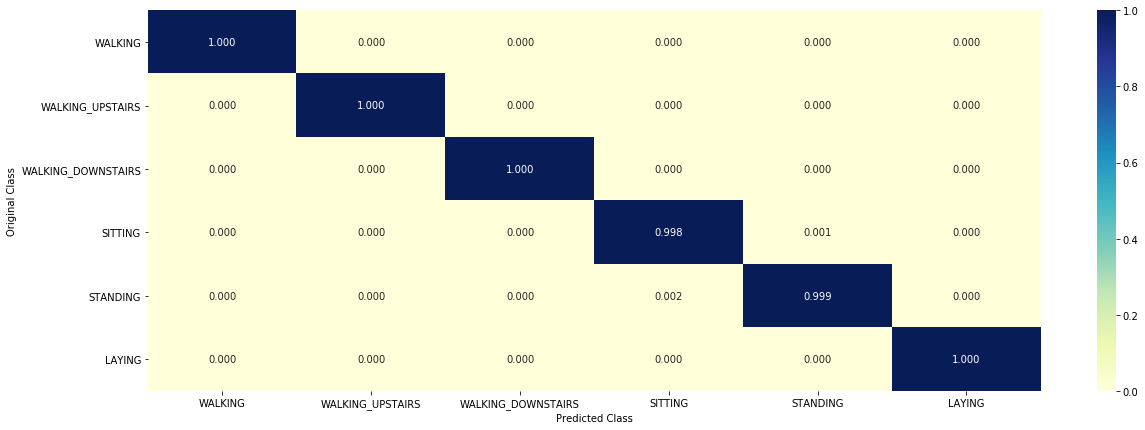

-------------------- Recall matrix (Row sum=1) --------------------


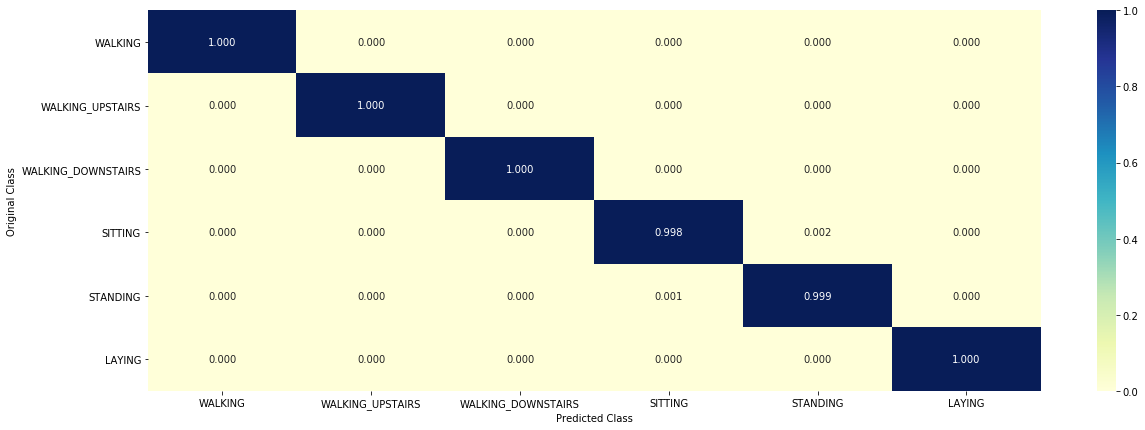

In [115]:
print("confusion matrix of train data")
plot_confusion_matrix(Y_train,train_pred)

confusion matrix of test data
-------------------- Confusion matrix --------------------


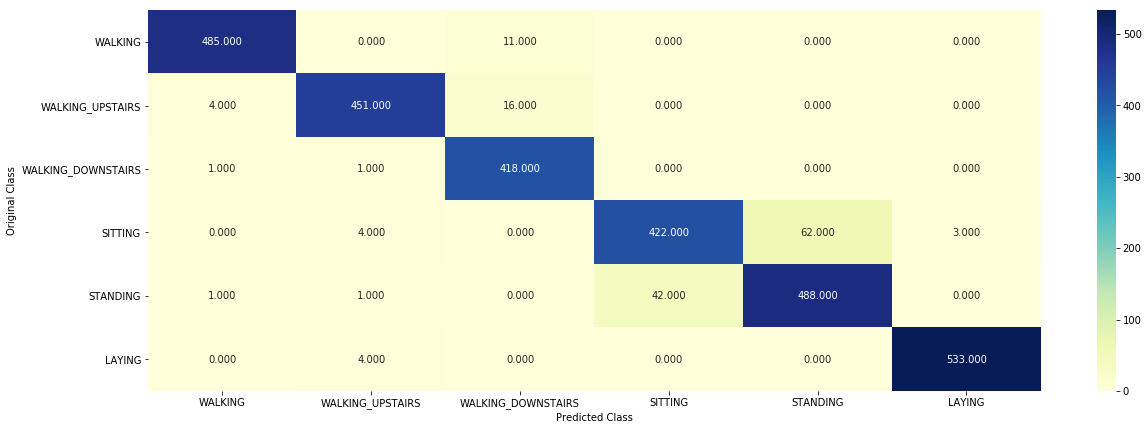

-------------------- Precision matrix (Columm Sum=1) --------------------


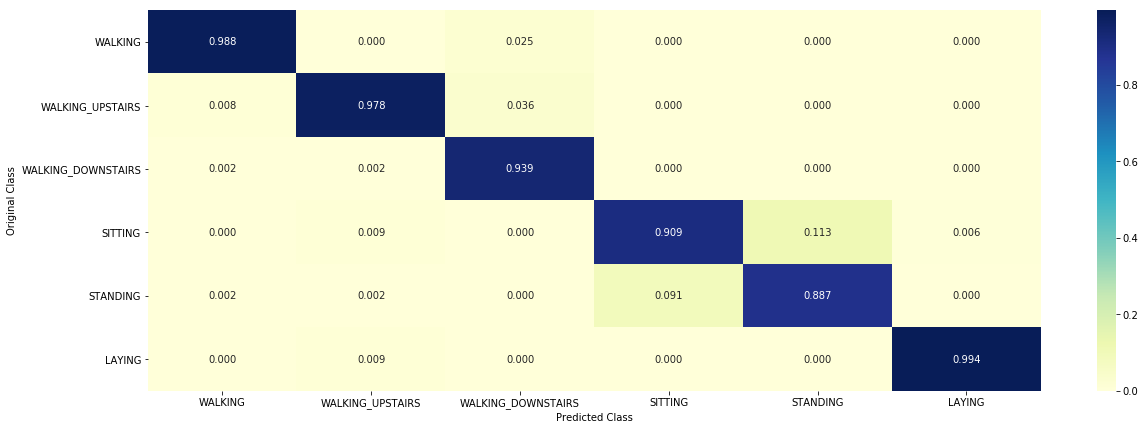

-------------------- Recall matrix (Row sum=1) --------------------


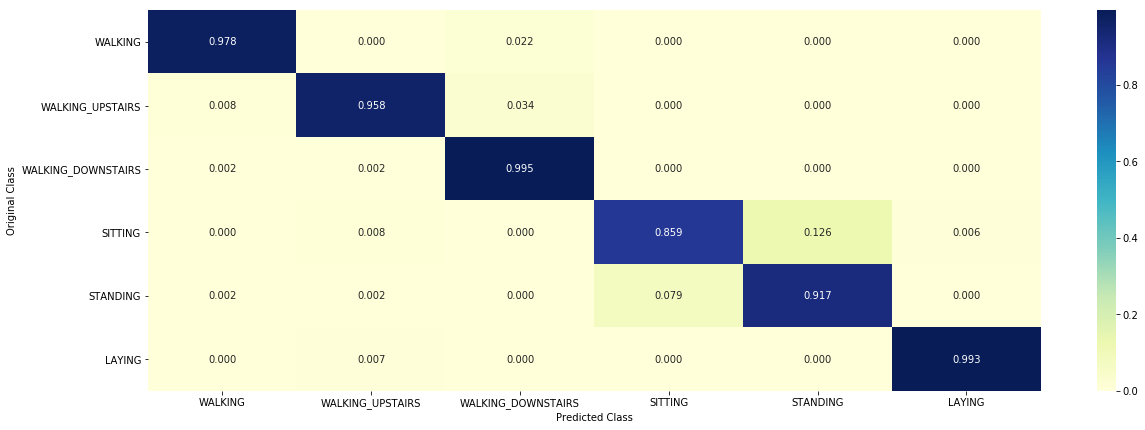

In [116]:
print("confusion matrix of test data")
plot_confusion_matrix(Y_test,test_pred)

#### Conclusions
* We could classify static and dynamic activities with more accurately
* All dynamic activities are classfied fairly well.
* In dynamic activities, there is some mis-classification between sitting and standing
* By using devide and conquer we have achieved 95% accuaracy